In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
SEED = 42

In [2]:
df = pd.read_csv("../data/list_attr_celeba.csv")
num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")
df.head()

Number of rows: 202599, Number of columns: 41


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


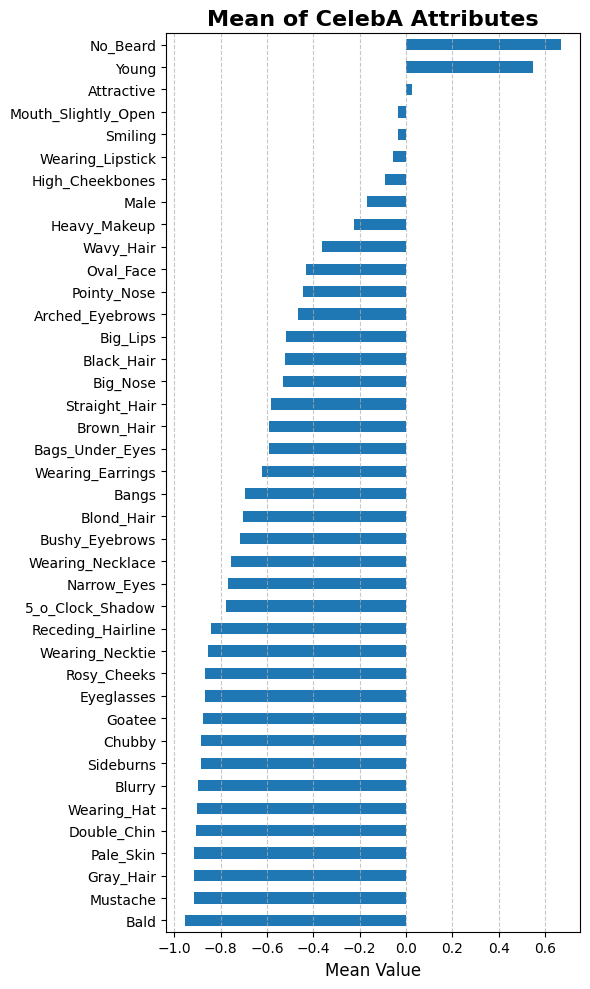

In [3]:
columns = df.columns.drop('image_id')
df[columns].mean(axis=0).sort_values().plot(kind='barh', figsize=(6, 10))
plt.title("Mean of CelebA Attributes", fontsize=16, fontweight='bold')
plt.xlabel("Mean Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

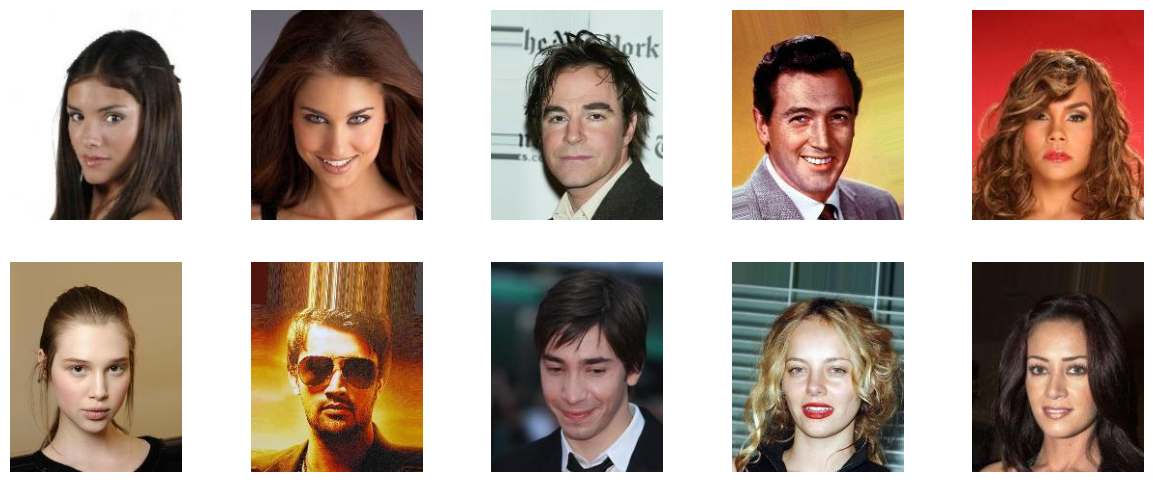

In [ ]:
num_people = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

def generate_imgs(randgen:np.random.default_rng,df:pd.DataFrame,num_people:int,axes:np.ndarray) -> None:
    """
    Generate random images from the CelebA dataset and display them in a grid.
    Parameters:
    randgen (np.random.default_rng): Random number generator for reproducibility.
    df (pd.DataFrame): DataFrame containing image metadata.
    num_people (int): Number of random images to display.
    axes (np.ndarray): Array of axes to plot the images on.
    """
    axes = axes.flatten()
    random_indices = randgen.integers(0, df.shape[0], size=num_people)
    formatted_indices = [df.iloc[idx]['image_id'] for idx in random_indices]
    for file,ax in zip(formatted_indices, axes):
        img = plt.imread("../data/img_align_celeba/img_align_celeba/"+file)
        ax.imshow(img)
        ax.axis('off')
generate_imgs(np.random.default_rng(SEED), df, num_people, axes)
plt.show()


# KOD PONIŻEJ DZIAŁA DOBRZE

Ładuje poprawnie dataset, dzieli na zbiory odpowiednie zgodnie z propozycją

In [25]:
import os
import pandas as pd
import tensorflow as tf

# 1. Load and inspect the partition CSV
def load_partition_csv(csv_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(csv_path)
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, encoding='latin1')
    # Expecting two columns without header: filename, partition (0=train,1=val,2=test)
    df.columns = ['filename', 'partition']
    return df

# 2. Build full filepaths and split lists
def build_file_lists(df: pd.DataFrame, image_dir: str) -> tuple[list, list, list]:
    # Map partition codes to masks
    train_mask = df['partition'] == 0
    val_mask   = df['partition'] == 1
    test_mask  = df['partition'] == 2

    # Prepend directory to filenames
    df['filepath'] = df['filename'].apply(lambda fn: os.path.join(image_dir, fn))

    train_files = df.loc[train_mask, 'filepath'].tolist()
    val_files   = df.loc[val_mask,   'filepath'].tolist()
    test_files  = df.loc[test_mask,  'filepath'].tolist()

    return train_files, val_files, test_files

# 3. Prepare tf.data.Dataset factory
def make_image_dataset(filepaths: list,img_size: tuple[int, int] = (218,178),
    batch_size: int = 64,shuffle: bool = False,buffer_size: int = 10000) -> tf.data.Dataset:
    """
    Returns a tf.data.Dataset yielding batches of normalized images.
    """
    ds = tf.data.Dataset.from_tensor_slices(filepaths)
    if shuffle:
        ds = ds.shuffle(buffer_size)

    def _load_and_preprocess(path):
        # Read raw bytes
        raw = tf.io.read_file(path)
        # Decode JPEG, force RGB
        img = tf.image.decode_jpeg(raw, channels=3)
        # Resize with bilinear interpolation
        img = tf.image.resize(img, img_size)
        # Normalize to [0,1]
        img = tf.cast(img, tf.float32) / 255.0
        return img

    # Parallelize map and prefetch
    ds = ds.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [31]:
csv_path  = '../data/list_eval_partition.csv'
image_dir = '../data/img_align_celeba/img_align_celeba/'

# Load partition info
df = load_partition_csv(csv_path)

# Build train/val/test file lists
train_files, val_files, test_files = build_file_lists(df, image_dir)

# Create datasets
train_ds = make_image_dataset(train_files, img_size=(218,178), batch_size=64, shuffle=False)
val_ds   = make_image_dataset(val_files,   img_size=(218, 178), batch_size=64)
test_ds  = make_image_dataset(test_files,  img_size=(218, 178), batch_size=64)

# Inspect one file from one batch
for batch in train_ds.take(1):
    print("Batch shape:", batch.shape)
    img_pil = tf.keras.utils.array_to_img(batch[np.random.randint(0, 64)])
    img_pil.show()

Batch shape: (64, 218, 178, 3)
